# Utils

In [5]:
from shapely.geometry import Point
import random
random.seed()


def get_bounding_box(row, gdf):
    aoi = Point(row.geometry.centroid.x, row.geometry.centroid.y).buffer(4750, cap_style=3)
    neighbors = gdf.clip(aoi)
    neighbors = neighbors.append(row)

    return neighbors, aoi

def get_random_bounding_box(gdf, gdf_ref):
    random_row = random.choice(gdf_ref.index.tolist())
    row = gdf_ref.loc[[random_row]]
    return get_bounding_box(row, gdf)

def compute_IoU(bounds1, bounds2):
    if bounds1.intersects(bounds2):
        IoU = bounds1.intersection(bounds2).area / bounds1.union(bounds2).area
    else: 
        IoU = 0
        
    return IoU

# Load data

In [29]:
import geopandas as gpd
import pandas as pd
from datetime import datetime
import os 

utm = 32631

directory = '/Users/arthurcalvi/Data/results/disturbances/matching_simplified_france_v05_EPSG32631.parquet'
#Load disturbances, convert to utm coordinates 
gdf = gpd.read_parquet(directory)

#filtering duplicates
display(gdf.shape[0])

assert gdf.crs.to_epsg() == utm


7642824

In [3]:
#Load greco regions


from shapely.ops import unary_union
#load greco
file = '/Users/arthurcalvi/Data/eco-regions/France/ser_l93_new/ser_l93_new.shp'
greco = gpd.read_file(file)

greco['GRECO'] = greco['codeser'].apply(lambda x: x[0])

#group polygon by the column GRECO
greco = greco.dissolve(by='GRECO')
greco.reset_index(inplace=True)
#drop étang de berre
greco = greco[greco['GRECO'] != '-']
greco.geometry = greco.geometry.normalize()
greco.geometry = greco.geometry.apply(unary_union)
#to UTM
greco = greco.to_crs(epsg=utm)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


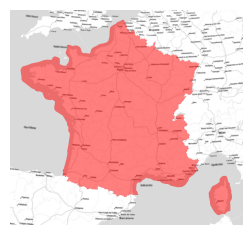

In [6]:
#les landes
#autorelaod
%load_ext autoreload
%autoreload 2
from utils import get_polygon

region_name = 'France métropolitaine'
region1, spatial_entity1 = get_polygon(region_name, epsg=utm)
# gironde, spatial_entity2 = get_polygon('Gironde, France', epsg=utm)

#put into a geodataframe with two columns geometry and name
region1 = gpd.GeoDataFrame(geometry=[region1], crs='EPSG:{}'.format(utm))
region1['name'] = region_name

# gironde = gpd.GeoDataFrame(geometry=[gironde], crs='EPSG:{}'.format(utm))
# gironde['name'] = 'Gironde'

# #merge
# landes = landes.append(gironde)
# landes.reset_index(inplace=True)
#plot les landes with base maps from contextily

import contextily as ctx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 3))
region1.plot(ax=ax, color='red', alpha=0.5)
ax.set_axis_off()
ctx.add_basemap(ax, crs=region1.crs.to_string(), source=ctx.providers.Stamen.TonerLite, attribution=False)

# Sampling

As stated by Cornelius Senf, the classifier is not as good on the test set as on real data. A lot of disturbances classified as fire are indeed insect attacks. So the Overal accuracy should be considered lower than 0.92. The classifier is not as good as it seems.

<Axes: xlabel='year', ylabel='class'>

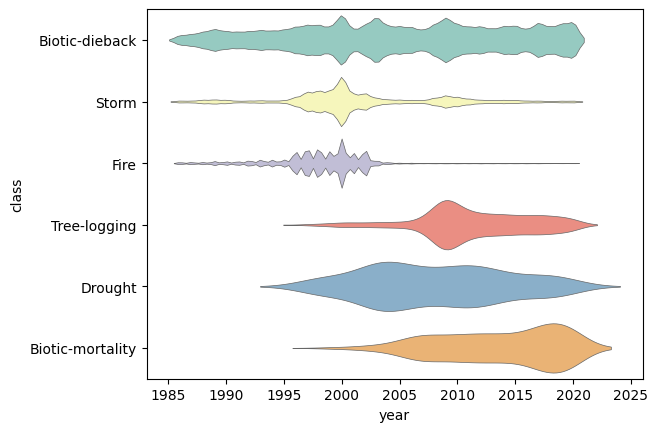

In [33]:
#violin plot discribing the probability (gdf['probability']) for each unique item of gdf['class']
import seaborn as sns
sns.violinplot(y=gdf['class'], x=gdf['year'],  \
               palette="Set3", scale='width', bw='silverman', \
                linewidth=0.5, inner=None)

<Axes: xlabel='probability', ylabel='class'>

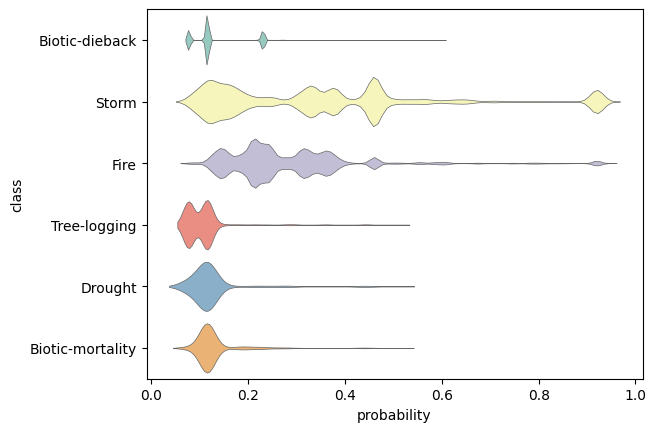

In [7]:
#violin plot discribing the probability (gdf['probability']) for each unique item of gdf['class']
import seaborn as sns
sns.violinplot(y=gdf['class'], x=gdf['probability'],  \
               palette="Set3", scale='width', bw='silverman', \
                linewidth=0.5, inner=None)


In [46]:
#Parameters 

dir_ = '/Users/arthurcalvi/Data/sampling/france-merged-dataset/'
os.makedirs(dir_, exist_ok=True)
n = 200
regions = greco
col_region = 'GRECO'
name_dict = 'dict_aoi_{}.pkl'.format(os.path.basename(dir_))
authorized_area = region1.geometry.iloc[0]

gdf_ = gdf.copy()
classes = gdf_['class'].unique().tolist()
n_class = len(classes)
n_region = regions[col_region].unique().shape[0]
N = int(n / (n_class * n_region))
print('Nbr of aoi to download per class and per region:', N)

Nbr of aoi to download per class and per region: 3


In [68]:
def rec_bounding_box(gdf, authorized_area, n=10):
    print(n)

    if len(gdf) == 0:
        return None, None
    
    random_row = random.choice(gdf.index.tolist())

    row = gdf.loc[random_row]

    #get 10x10km aoi
    aoi = Point(row.geometry.centroid.x, row.geometry.centroid.y).buffer(4750, cap_style=3)

    area_intersected_perc = authorized_area.intersection(aoi).area / aoi.area 

    if area_intersected_perc > 0.9:
        return aoi, row
    elif n < 0:
        return None, None 
    else :
        return rec_bounding_box(gdf, authorized_area, n=n-1)
    

In [69]:
#TODO: create by iteration a GeoDataFrame with the same columns as gdf and having all the disturbances. Should be ok 
#TODO: change the sampling process to have better distribution of eacj disturbance in time. Use 3 timeperiods : 1984-1999 (L5), 2000-2014(L5-L7), 2015-2023 (L8-S2)

from datetime import datetime, timedelta, timezone
from rasterio.warp import transform_geom
from shapely.geometry import shape 


#import tqdm notebook
from tqdm.notebook import tqdm

#avoid FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


regions.geometry = regions.geometry.buffer(7000).simplify(7000)

delta = timedelta(days=3*365)
path = os.path.join(dir_, name_dict)
list_aoi = []
dict_count_class = {name:0 for name in gdf_['class'].unique()}

gdf_disturbances = gpd.GeoDataFrame(columns=gdf.columns, crs='EPSG:{}'.format(utm))

#REGION iteration
for region in tqdm(regions[col_region].unique()):
  
    geometry = regions[regions[col_region] == region].geometry.iloc[0]
    gdf_region = gdf_.clip(geometry)

    

    #sort dict_count_class keys by decreasing value
    classes = [x for x  in sorted(dict_count_class, key=dict_count_class.get) if x in gdf_region['class'].unique()]
    
    #CAUSE iteration 
    # count_class_region = {name:0 for name in classes}
    for cause in tqdm(classes):
        
        for i in range(N):
            # #NUMBER conditon on aoi to donwnlaod per class and per region
            # if count_class_region[cause] >= N:
            #     pass 
            # else :
            gdf_class = gdf_region[gdf_region['class'] == cause]

            aoi, random_row = rec_bounding_box(gdf_class, authorized_area, n=25)

            if aoi is None:
                pass

            else :
                #Select neighbors and delete them. 
                neighbors = gdf_class.clip(aoi)
                neighbors = neighbors.append(random_row)
                neighbors.drop_duplicates(inplace=True)

                #Add neighbors to gdf_disturbances
                gdf_disturbances = gdf_disturbances.append(neighbors)
                gdf_ = gdf_[~gdf_.index.isin(neighbors.index)]
                gdf_region = gdf_region[~gdf_region.index.isin(neighbors.index)]
                gdf_class = gdf_class[~gdf_class.index.isin(neighbors.index)]

                neighbors.reset_index(inplace=True, drop=True)

                #Remove the aoi area from the authorized one. 
                authorized_area = authorized_area.difference(aoi)

                #account for disturbances in this aoi
                for i in range(neighbors.shape[0]):
                    c = neighbors.iloc[i]['class']
                    dict_count_class[c] = dict_count_class[c] + 1 

                list_aoi.append((aoi, region, cause))

                # count_class_region[cause] = count_class_region[cause] + 1

gdf_aoi = gpd.GeoDataFrame(list_aoi, columns=['geometry', 'region', 'cause'], crs='EPSG:{}'.format(utm))

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

25
25
25
24
25
25
25
25
25
25
24
25
25
24
25
24
25
25
25


  0%|          | 0/5 [00:00<?, ?it/s]

25
25
25
25
25
24
25
25
25
25
25
25
24
25
25
25
25


  0%|          | 0/6 [00:00<?, ?it/s]

25
25
25
25
25
25
25
24
23
25
25
25
24
25
25
24
25
24
25
25
25
24
25
25


  0%|          | 0/6 [00:00<?, ?it/s]

25
25
25
25
25
25
24
25
25
25
25
24
25
24
23
22
21
25
24
25
25
24
23
22
21
20
19
25
24
25
25
24
25
24
23


  0%|          | 0/6 [00:00<?, ?it/s]

25
24
25
25
25
25
25
25
25
25
24
25
25
24
25
25
25
24
25
25
25
25


  0%|          | 0/6 [00:00<?, ?it/s]

25
25
25
25
25
25
24
23
25
25
25
24
23
22
21
20
19
18
17
25
24
23
22
21
20
25
24
25
25
25
25
24
23
25
24
25
25


  0%|          | 0/6 [00:00<?, ?it/s]

25
25
25
25
25
25
25
24
25
25
25
25
25
24
25
25
24
25
25
25
25


  0%|          | 0/6 [00:00<?, ?it/s]

25
25
25
24
25
25
24
23
25
25
24
23
25
24
23
22
25
24
25
25
25
25
25
25
25
24
23
25
25


  0%|          | 0/6 [00:00<?, ?it/s]

25
25
25
25
25
25
25
24
25
24
25
24
25
24
25
25
25
25
25
25
24
23
25
25
24


  0%|          | 0/6 [00:00<?, ?it/s]

25
24
25
25
25
25
25
24
25
24
25
24
23
22
25
25
24
23
25
25
24
25
25
25
25
25
24
25


  0%|          | 0/5 [00:00<?, ?it/s]

25
25
25
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
-1
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
-1
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
-1
25
25
25
24
25
25
25
25
24
25
24
25
24
23
22
21


In [70]:
display(dict_count_class)

{'Biotic-dieback': 41698,
 'Storm': 26327,
 'Fire': 17903,
 'Tree-logging': 262,
 'Drought': 115,
 'Biotic-mortality': 155}

In [72]:
neighbors = gdf[ ~gdf.index.isin(gdf_.index) ]
neighbors.dropna(inplace=True)
neighbors['class'].value_counts()

/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_9327/2881777712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors.dropna(inplace=True)


Storm               17007
Biotic-dieback       9148
Fire                 5934
Tree-logging           59
Drought                23
Biotic-mortality       23
Name: class, dtype: int64

<Axes: xlabel='probability', ylabel='class'>

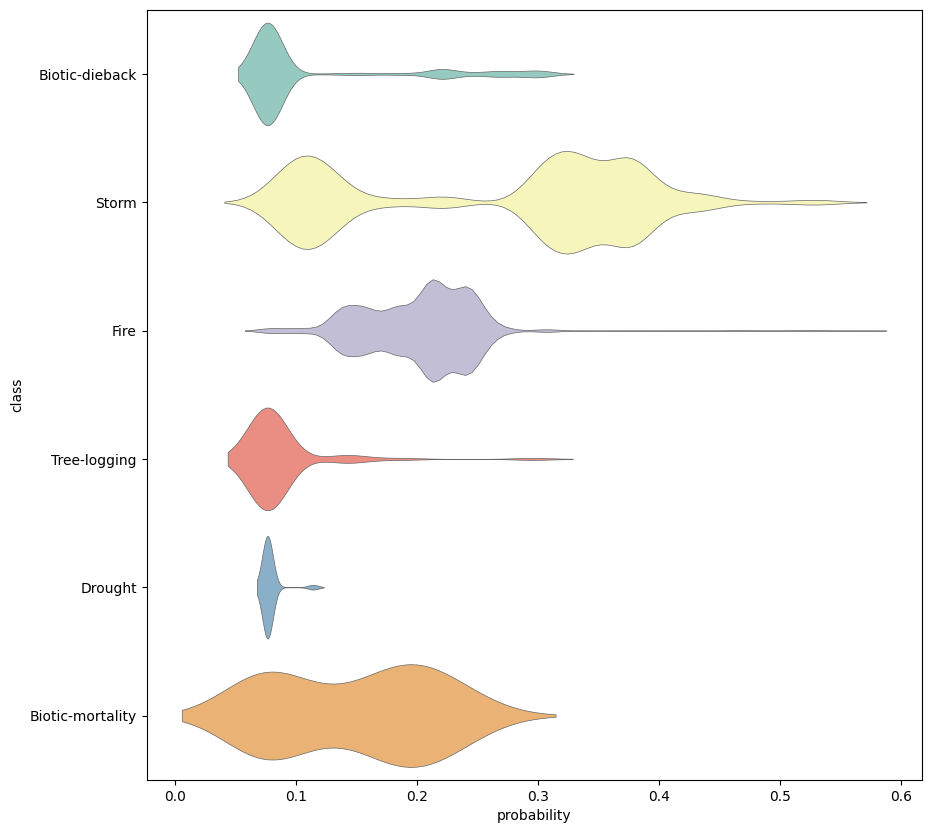

In [75]:
#analyze the probability distribution
#TODO change to swarmplot or boxplot
import seaborn as sns
sns.violinplot(y=neighbors['class'], x=gdf['probability'],  \
               palette="Set3", scale='width', bw='silverman', \
                linewidth=0.5, inner=None)

<Axes: xlabel='year', ylabel='class'>

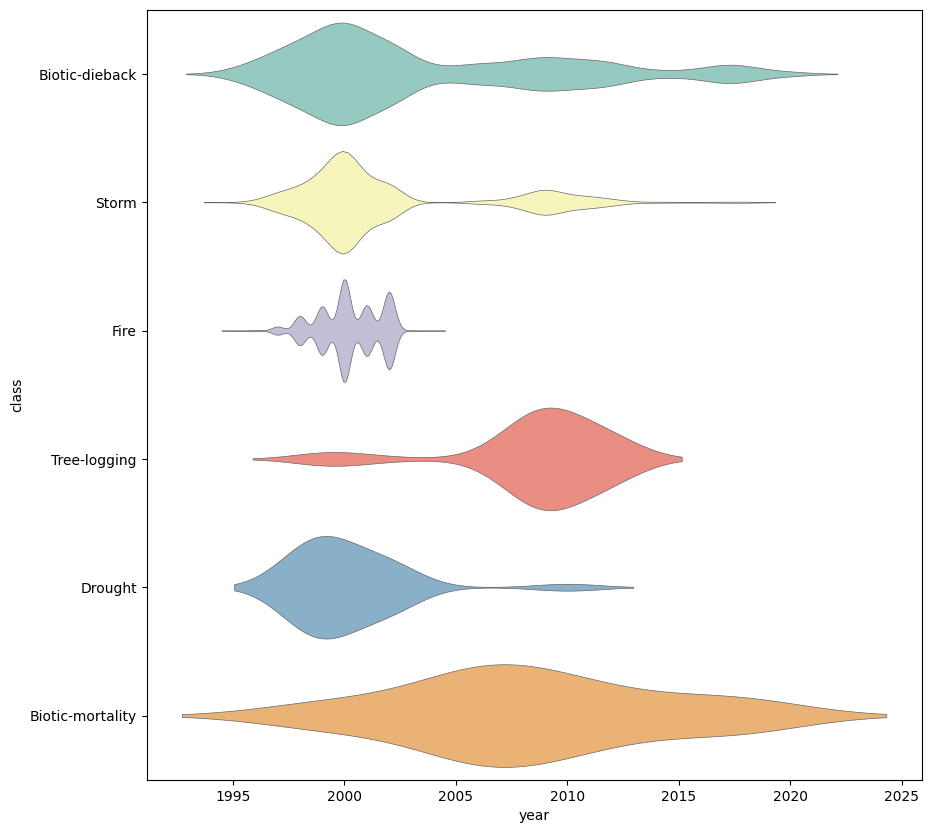

In [76]:
#analyze the date distribution
import seaborn as sns
sns.violinplot(y=neighbors['class'], x=gdf['year'],  \
               palette="Set3", scale='width', bw='silverman', \
                linewidth=0.5, inner=None)

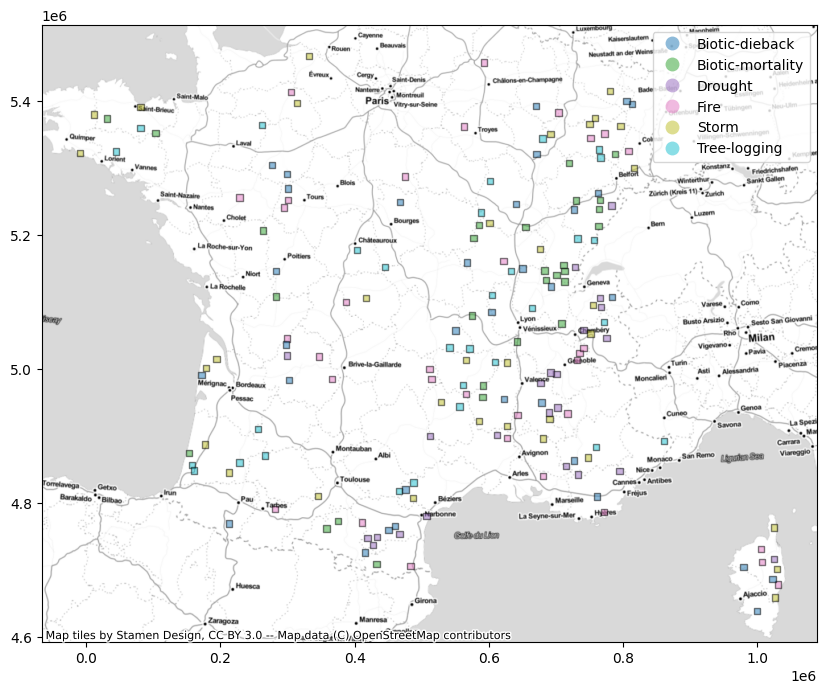

In [77]:
#plot gdf_aoi with basemap from contextily
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)

ax = gdf_aoi.plot(alpha=0.5, edgecolor='k', column='cause', legend=True)
ctx.add_basemap(ax, crs=gdf_aoi.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
plt.show()